# Simulate base model

In [215]:
import numpy as np
import matplotlib.pyplot as plt

In [216]:
# define constants

sigma_B = 5.6696e-8 # W/(m^2 K^4)
sigma_B_scaled = 5.6696
solar_const = 1368 # W/m^2
r_earth = 6371e3 # m
area_earth = np.pi * r_earth**2
emissivity_earth = 1
transmissivity_atm = 0.63
albedo_sky = 0.2
albedo_surface = 0.4
albedo_ocean = 0.1
albedo_ice = 0.6
density_land = 2500 # kg/m^3
density_water = 1028 # kg/m^3
density_ice = 900 # kg/m^3
depth_land = 1 # m
depth_ocean = 70 # m
depth_ice = 1 # m
spec_heat_land = 790 # J kg/K
spec_heat_water = 4187 # J kg/K
spec_heat_ice = 2060 # J kg/K

# zonal properties
area_fractions = np.array([0.0670, 0.1830, 0.2500, 0.2500, 0.1830, 0.0670])
geometric_factors = np.array([0.1076, 0.2277, 0.3045, 0.3045, 0.2277, 0.1076])
land_fractions = [0.008, 0.0116, 0.2522, 0.3550, 0.5786, 0.0020]
ocean_fractions = [0.2901, 0.9880, 0.7472, 0.6442, 0.4176, 0.6310]
ice_fractions = [0.7019, 0.0004, 0.0006, 0.0008, 0.0038, 0.3670]

# zonal exchanges
lengths = np.array([2.0015e7, 3.4667e7, 4.0030e7, 3.4667e7, 2.0015e7]) # m
# k_vals = np.zeros(5)
k_vals = np.array([1e7, 1e7, 1e7, 5e7, 1e7]) # W / (m K)

In [217]:
def compute_pcZ(p, c, z):
    return p * c * z

def compute_albedo(a):
    return a

def average_fcn(f, func, *args):
    """Takes in a list of length 3 for each of the input variables and returns 
    the weighted average based on the fraction f"""
    f = np.array(f)
    assert np.isclose(np.sum(f), 1.0), "Fractions must sum to 1"
    assert np.min(f) >= 0, "Fractions cannot be negative"

    total = 0
    for i in range(len(f)):
        # Pass the i-th element of each argument list into func
        total += f[i] * func(*[arg[i] for arg in args])
    return total

frac_arr = np.vstack([land_fractions, ocean_fractions, ice_fractions])
density_arr = np.array([density_land, density_water, density_ice])
spec_heat_arr = np.array([spec_heat_land, spec_heat_water, spec_heat_ice])
depth_arr = np.array([depth_land, depth_ocean, depth_ice])
albedo_arr = np.array([albedo_surface, albedo_ocean, albedo_ice])

avg_albedos = np.array([average_fcn(frac_arr[:,i], compute_albedo, albedo_arr) for i in range(frac_arr.shape[1])])
pcZ_vals = np.array([average_fcn(frac_arr[:,i], compute_pcZ, density_arr, spec_heat_arr, depth_arr) for i in range(frac_arr.shape[1])])

def compute_dT(temp, phi):
    dT = (geometric_factors * (1 - albedo_sky) * (1 - avg_albedos) * phi * solar_const - transmissivity_atm * sigma_B_scaled * (temp/100)**4) / pcZ_vals
    dT[:-1] += lengths * k_vals * (temp[1:] - temp[:-1]) / (area_earth * area_fractions[:-1] * pcZ_vals[:-1])
    dT[1:] -= lengths * k_vals * (temp[1:] - temp[:-1]) / (area_earth * area_fractions[1:] * pcZ_vals[1:])
    return dT

def eruption_event(t, cell, magnitude=0.4):
    """Magnitude: 1 for nuclear winter and 0 for no eruption"""
    """Assumes a 60x60 degree square"""
    time_constant = 86400 * 365 # 1 year
    time_component = magnitude * np.exp(-t / time_constant)
    phi = np.ones(6)
    if cell == 0 or cell == 5:
        phi[cell] = 1 - time_component * 2 / 3
    else:
        phi[cell] = 1 - time_component / 3
        phi[cell-1] = 1 - time_component / 6
        phi[cell+1] = 1 - time_component / 6
    return phi


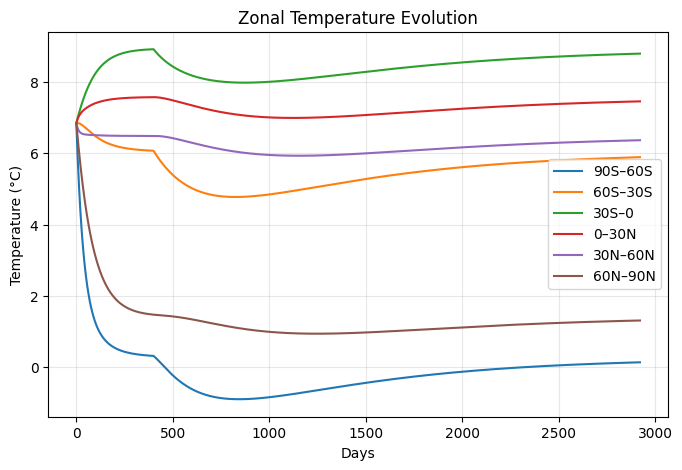

In [218]:
# Parameters
n_zones = 6
lat_labels = ['90S–60S', '60S–30S', '30S–0', '0–30N', '30N–60N', '60N–90N']
dt = 3600 * 24  # time step (seconds)
n_steps = 365 * 8 # years

# Initial temperature
temp = np.ones(6) * 280  # initial guess
temps_over_time = [temp.copy()]

phi = np.ones(6)

# Time integration
for n in range(n_steps):
    time = dt * n
    if n >= 400:
        phi = eruption_event(time - dt * 400, 1, magnitude=0.4)
    dT = compute_dT(temp, phi)
    temp = temp + dT * dt
    temps_over_time.append(temp.copy())

temps_over_time = np.array(temps_over_time)
times = np.arange(len(temps_over_time))

# --- Plot 1: Time series of zonal temperatures ---
plt.figure(figsize=(8, 5))
for i, label in enumerate(lat_labels):
    plt.plot(times, temps_over_time[:, i] - 273.15, label=label)
plt.xlabel("Days")
plt.ylabel("Temperature (°C)")
plt.title("Zonal Temperature Evolution")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Set up longitudinal case

In [253]:
import numpy as np
from scipy import integrate

In [306]:
# define constants

sigma_B = 5.6696e-8 # W/(m^2 K^4)
sigma_B_scaled = 5.6696
solar_const = 1368 # W/m^2
r_earth = 6371e3 # m
area_earth = 4 * np.pi * r_earth**2 # m^2 (different from assignment instructions by factor of 4)
emissivity_earth = 1
transmissivity_atm = 0.63
albedo_sky = 0.2
albedo_surface = 0.4
albedo_ocean = 0.1
albedo_ice = 0.6
density_land = 2500 # kg/m^3
density_water = 1028 # kg/m^3
density_ice = 900 # kg/m^3
depth_land = 1 # m
depth_ocean = 70 # m
depth_ice = 1 # m
spec_heat_land = 790 # J kg/K
spec_heat_water = 4187 # J kg/K
spec_heat_ice = 2060 # J kg/K

# rotational constants
day_length = 24 * 3600 # s
# earth_tilt = 23.5 # degree
earth_tilt = 0
year_length = 365 * day_length # s

# derived rotation constants
earth_rot_speed = 360 / day_length # deg / s

# zonal properties
area_fractions = np.array(12*[[0.0670, 0.1830, 0.2500, 0.2500, 0.1830, 0.0670]]) / 12
# geometric_factors = np.array(12*[[0.1076, 0.2277, 0.3045, 0.3045, 0.2277, 0.1076]])

lat_edges = np.arange(-90, 91, 30)   # -90 to 90 by 30
lon_edges = np.arange(-180, 181, 30) # -180 to 180 by 30

grid = []

for j in range(len(lon_edges) - 1):      # 12 longitude bands
    for i in range(len(lat_edges) - 1):  # 6 latitude bands
        lat1, lat2 = lat_edges[i], lat_edges[i+1]
        lon1, lon2 = lon_edges[j], lon_edges[j+1]
        grid.append((lat1, lat2, lon1, lon2))

grid = np.array(grid).reshape(12, 6, 4)

# zonal exchanges
lengths_lat = np.array(12*[[2.0015e7, 3.4667e7, 4.0030e7, 3.4667e7, 2.0015e7]]) / 12 # m
lengths_lon = np.array(12*[6*[np.pi * r_earth]]) / 6 # m
k_vals_lat = np.ones((12,5)) * 1e7 # W / (m K)
k_vals_lon = np.ones((12,6)) * 1e7 # W / (m K)

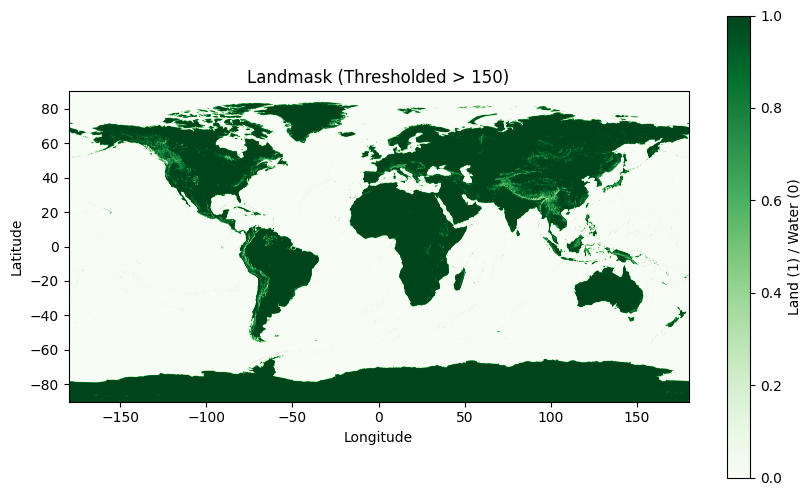

In [270]:
import numpy as np
import rasterio
from rasterio.features import dataset_features

# Download manually (one time) or via requests:
# https://www.naturalearthdata.com/downloads/50m-raster-data/50m-natural-earth-1/

# Let's assume you have: 'NE1_50M_SR.tif'
path = "NE1_50M_SR_W.tif"

with rasterio.open(path) as src:
    data = src.read(1)
    transform = src.transform

# Natural Earth “Natural Earth 1” raster encodes land/water by color intensity.
# A better dataset for clear 0/1 classification is “NE2_landmask”.
# If using NE1, threshold the brightness (values > 128 = land, else water):
landmask = (data > 150).astype(int)

# Build coordinate arrays
nlat, nlon = landmask.shape
lons = np.linspace(-180, 180, nlon, endpoint=False)
lats = np.linspace(90, -90, nlat, endpoint=False)

# Define 30° bins
lon_bins = np.arange(-180, 181, 30)
lat_bins = np.arange(-90, 91, 30)

# Compute fraction land in each 30°×30° cell
frac_land = np.zeros((len(lat_bins)-1, len(lon_bins)-1))

for i in range(len(lat_bins)-1):
    for j in range(len(lon_bins)-1):
        lat_mask = (lats <= lat_bins[i+1]) & (lats > lat_bins[i])
        lon_mask = (lons >= lon_bins[j]) & (lons < lon_bins[j+1])
        sub = landmask[np.ix_(lat_mask, lon_mask)]
        frac_land[i,j] = sub.mean()  # fraction land in cell

frac_water = 1 - frac_land

plt.figure(figsize=(10, 6))
plt.imshow(landmask, cmap='Greens', extent=[-180, 180, -90, 90])
plt.title("Landmask (Thresholded > 150)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.colorbar(label="Land (1) / Water (0)")
plt.show()

In [271]:
arctic_ice = 0.367
antarctic_ice = 0.7019

land_fractions = frac_land.T
ocean_fractions = frac_water.T

land_fractions[:,0] *= (1 - antarctic_ice)
land_fractions[:,-1] *= (1 - arctic_ice)
ocean_fractions[:,0] *= (1 - antarctic_ice)
ocean_fractions[:,-1] *= (1 - arctic_ice)

ice_fractions = np.zeros_like(land_fractions)
ice_fractions[:,0] = antarctic_ice
ice_fractions[:,-1] = arctic_ice

In [348]:
def compute_pcZ(p, c, z):
    return p * c * z

def compute_albedo(a):
    return a

def average_fcn(f, func, *args):
    """Takes in a list of length 3 for each of the input variables and returns 
    the weighted average based on the fraction f"""
    f = np.array(f)
    assert np.isclose(np.sum(f), 1.0), "Fractions must sum to 1"
    assert np.min(f) >= 0, "Fractions cannot be negative"

    total = 0
    for i in range(len(f)):
        # Pass the i-th element of each argument list into func
        total += f[i] * func(*[arg[i] for arg in args])
    return total

def unit_radius_flux(lat1, lat2, lon1, lon2):
    lats = [np.radians(lat1), np.radians(lat2)]
    lons = [np.radians(lon1), np.radians(lon2)]
    flux = (np.sin(lons[1]) - np.sin(lons[0])) * ((lats[1] - lats[0]) / 2 + (np.sin(2*lats[1]) - np.sin(2*lats[0])) / 4)
    return np.absolute(flux)

def wrap_to_180(deg):
    return ((deg + 180) % 360) - 180


def compute_flux(phi1, phi2, theta1, theta2, alpha):
    def integrand(theta, phi):
        val = np.cos(theta) * np.cos(phi) * np.cos(alpha) + np.sin(theta) * np.sin(alpha)
        return np.maximum(0.0, val) * np.cos(theta)

    # Integrate using dblquad: inner integral over theta, outer over phi
    result, err = integrate.dblquad(
        lambda phi, theta: integrand(theta, phi),
        theta1, theta2,  # inner integral limits
        lambda _: phi1,
        lambda _: phi2
    )
    return result

# grid spaced version of flux computation
def compute_flux_fast(phi1, phi2, theta1, theta2, alpha, n_phi=60, n_theta=60):
    phi = np.linspace(phi1, phi2, n_phi)
    theta = np.linspace(theta1, theta2, n_theta)
    dphi = (phi2 - phi1) / (n_phi - 1)
    dtheta = (theta2 - theta1) / (n_theta - 1)

    phi_grid, theta_grid = np.meshgrid(phi, theta)
    val = np.cos(theta_grid) * np.cos(phi_grid) * np.cos(alpha) + np.sin(theta_grid) * np.sin(alpha)
    integrand = np.maximum(0.0, val) * np.cos(theta_grid)

    return np.sum(integrand) * dphi * dtheta

def time_dependent_flux(time, lat1, lat2, lon1, lon2):
    # compute effects of rotating earth
    time_of_day = time % day_length
    delta_degree = time_of_day * earth_rot_speed
    lon1_shift = wrap_to_180(lon1 + delta_degree)
    lon2_shift = wrap_to_180(lon2 + delta_degree)
    # compute seasonal angle
    time_of_year = time % year_length
    alpha = np.radians(earth_tilt) * np.sin(2*np.pi * time_of_year / year_length)
    return compute_flux_fast(np.radians(lon1_shift), np.radians(lon2_shift), np.radians(lat1), np.radians(lat2), alpha)

frac_arr = np.vstack([np.ndarray.flatten(land_fractions),
                      np.ndarray.flatten(ocean_fractions),
                      np.ndarray.flatten(ice_fractions)])
density_arr = np.array([density_land, density_water, density_ice])
spec_heat_arr = np.array([spec_heat_land, spec_heat_water, spec_heat_ice])
depth_arr = np.array([depth_land, depth_ocean, depth_ice])
albedo_arr = np.array([albedo_surface, albedo_ocean, albedo_ice])

avg_albedos = np.array([average_fcn(frac_arr[:,i], compute_albedo, albedo_arr) for i in range(frac_arr.shape[1])]).reshape((12,6))
pcZ_vals = np.array([average_fcn(frac_arr[:,i], compute_pcZ, density_arr, spec_heat_arr, depth_arr) for i in range(frac_arr.shape[1])]).reshape((12,6))

def compute_dT(temp, time):
    # compute geometric factors based on the part of the earth facing the sun
    geometric_factors = np.empty((12, 6))
    for i in range(12):
        for j in range(6):
            geometric_factors[i, j] = time_dependent_flux(time, *grid[i, j])
    # single cell energy balance
    dT = (geometric_factors * (1 - albedo_sky) * (1 - avg_albedos) * solar_const - transmissivity_atm * sigma_B_scaled * (temp/100)**4) / pcZ_vals
    # latitude transitions
    dT[:,:-1] += lengths_lat * k_vals_lat * (temp[:,1:] - temp[:,:-1]) / (area_earth * area_fractions[:,:-1] * pcZ_vals[:,:-1])
    dT[:,1:] -= lengths_lat * k_vals_lat * (temp[:,1:] - temp[:,:-1]) / (area_earth * area_fractions[:,1:] * pcZ_vals[:,1:])
    # longitude transitions
    dT[:-1] += lengths_lon[:-1] * k_vals_lon[:-1] * (temp[1:] - temp[:-1]) / (area_earth * area_fractions[:-1] * pcZ_vals[:-1])
    dT[1:] -= lengths_lon[:-1] * k_vals_lon[:-1] * (temp[1:] - temp[:-1]) / (area_earth * area_fractions[1:] * pcZ_vals[1:])
    # longitude wrap around
    dT[0] -= lengths_lon[-1] * k_vals_lon[-1] * (temp[0] - temp[-1]) / (area_earth * area_fractions[0] * pcZ_vals[0])
    dT[-1] += lengths_lon[-1] * k_vals_lon[-1] * (temp[0] - temp[-1]) / (area_earth * area_fractions[-1] * pcZ_vals[-1])
    return dT

In [248]:
time_dependent_flux(3600*24, 0, 30, 0, 30)

0.2391528693726295

In [364]:
compute_flux_fast(0, np.pi/6, 0, np.pi/6, 0, n_phi=512, n_theta=60)/ unit_radius_flux(0, 30, 0, 30)

1.018165958736921

In [351]:
temp = np.ones((12,6)) * 280  # initial guess

# Assuming temp is a 12x6 array (lon x lat)
nlon, nlat = temp.shape
dt = 3600 * 0.5  # time step (seconds)
# nsteps = 365 * 1 # years
nsteps = 48 * 10
# nsteps = 300

# Store results over time
temps = np.zeros((nsteps, nlon, nlat))
temps[0] = temp

total_time = 0
for t in range(1, nsteps):
    temps[t,:,:] = temps[t-1] + compute_dT(temps[t-1], total_time) * dt
    total_time += dt
    print(f"Completed time step: {t}")

# convert to C
temps -= 273.15

Completed time step: 1
Completed time step: 2
Completed time step: 3
Completed time step: 4
Completed time step: 5
Completed time step: 6
Completed time step: 7
Completed time step: 8
Completed time step: 9
Completed time step: 10
Completed time step: 11
Completed time step: 12
Completed time step: 13
Completed time step: 14
Completed time step: 15
Completed time step: 16
Completed time step: 17
Completed time step: 18
Completed time step: 19
Completed time step: 20
Completed time step: 21
Completed time step: 22
Completed time step: 23
Completed time step: 24
Completed time step: 25
Completed time step: 26
Completed time step: 27
Completed time step: 28
Completed time step: 29
Completed time step: 30
Completed time step: 31
Completed time step: 32
Completed time step: 33
Completed time step: 34
Completed time step: 35
Completed time step: 36
Completed time step: 37
Completed time step: 38
Completed time step: 39
Completed time step: 40
Completed time step: 41
Completed time step: 42
C

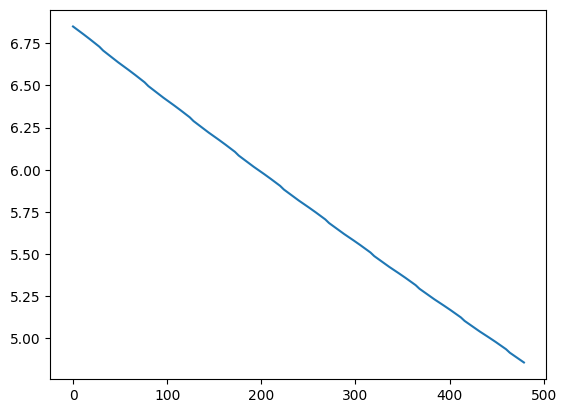

In [362]:
plt.plot(temps[:,4,5])

In [353]:
import numpy as np
import plotly.graph_objects as go

def create_globe_visualization(temps):
    """
    Create an interactive 3D globe with temperature heatmap and time slider.
    
    Parameters:
    -----------
    temps : np.ndarray
        Temperature array of shape (nsteps, nlon, nlat) where:
        - nsteps: number of time steps
        - nlon: 12 (longitude bins)
        - nlat: 6 (latitude bins)
    """
    nsteps, nlon, nlat = temps.shape
    
    # Define lat/lon grid centers
    lat_centers = np.linspace(-75, 75, nlat)  # centers of 30-degree bands
    lon_centers = np.linspace(-165, 165, nlon)  # centers of 30-degree bands
    
    # Create meshgrid for plotting
    lon_grid, lat_grid = np.meshgrid(lon_centers, lat_centers)
    
    # Create frames for animation
    frames = []
    
    for step in range(nsteps):
        # Transpose to match lat x lon orientation for plotting
        temp_data = temps[step].T
        
        # Create frame
        frame = go.Frame(
            data=[go.Scattergeo(
                lon=lon_grid.flatten(),
                lat=lat_grid.flatten(),
                mode='markers',
                marker=dict(
                    size=20,
                    color=temp_data.flatten(),
                    colorscale='RdBu_r',
                    cmin=temps.min(),
                    cmax=temps.max(),
                    colorbar=dict(
                        title="Temperature (°C)",
                        thickness=20,
                        len=0.7
                    ),
                    line=dict(width=0)
                ),
                text=[f"Lat: {lat:.0f}°, Lon: {lon:.0f}°<br>Temp: {temp:.1f}°C" 
                      for lat, lon, temp in zip(lat_grid.flatten(), lon_grid.flatten(), temp_data.flatten())],
                hovertemplate='%{text}<extra></extra>'
            )],
            name=str(step)
        )
        frames.append(frame)
    
    # Create initial figure
    initial_data = temps[0].T
    
    fig = go.Figure(
        data=[go.Scattergeo(
            lon=lon_grid.flatten(),
            lat=lat_grid.flatten(),
            mode='markers',
            marker=dict(
                size=20,
                color=initial_data.flatten(),
                colorscale='RdBu_r',
                cmin=temps.min(),
                cmax=temps.max(),
                colorbar=dict(
                    title="Temperature (°C)",
                    thickness=20,
                    len=0.7
                ),
                line=dict(width=0)
            ),
            text=[f"Lat: {lat:.0f}°, Lon: {lon:.0f}°<br>Temp: {temp:.1f}°C" 
                  for lat, lon, temp in zip(lat_grid.flatten(), lon_grid.flatten(), initial_data.flatten())],
            hovertemplate='%{text}<extra></extra>'
        )],
        frames=frames
    )
    
    # Add slider and play button
    sliders = [dict(
        active=0,
        yanchor="top",
        y=0.05,
        xanchor="left",
        x=0.05,
        currentvalue=dict(
            prefix="Day: ",
            visible=True,
            xanchor="right"
        ),
        transition=dict(duration=50),
        pad=dict(b=10, t=50),
        len=0.9,
        steps=[dict(
            args=[[f.name], dict(
                frame=dict(duration=50, redraw=True),
                mode="immediate",
                transition=dict(duration=50)
            )],
            method="animate",
            label=str(k)
        ) for k, f in enumerate(frames)]
    )]
    
    # Add play/pause buttons
    updatemenus = [dict(
        type="buttons",
        direction="left",
        x=0.05,
        y=0.15,
        xanchor="left",
        yanchor="top",
        pad=dict(r=10, t=10),
        buttons=[
            dict(
                label="▶ Play",
                method="animate",
                args=[None, dict(
                    frame=dict(duration=50, redraw=True),
                    fromcurrent=True,
                    transition=dict(duration=50)
                )]
            ),
            dict(
                label="⏸ Pause",
                method="animate",
                args=[[None], dict(
                    frame=dict(duration=0, redraw=False),
                    mode="immediate",
                    transition=dict(duration=0)
                )]
            )
        ]
    )]
    
    # Update layout for 3D globe
    fig.update_geos(
        projection_type="orthographic",
        showland=True,
        landcolor="lightgray",
        showocean=True,
        oceancolor="lightblue",
        showlakes=True,
        lakecolor="lightblue",
        showcountries=True,
        countrycolor="white",
        coastlinecolor="white",
        projection_rotation=dict(lon=0, lat=0, roll=0)
    )
    
    fig.update_layout(
        title=dict(
            text="Surface Energy Balance Model - Global Temperature",
            x=0.5,
            xanchor="center"
        ),
        sliders=sliders,
        updatemenus=updatemenus,
        height=800,
        margin=dict(l=0, r=0, t=50, b=0)
    )
    
    return fig

# Example usage with your temps array:
# Assuming temps is your (nsteps, 12, 6) array
fig = create_globe_visualization(temps)
fig.show()

# Alternative: Save as HTML file
# fig.write_html("temperature_globe.html")